In [1]:
%matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the `get_data.py` script in the `data` folder in the root directory of this repo.

In [3]:
with pd.HDFStore('../../data/assets.h5') as store:
    prices = store['quandl/wiki/prices'].loc[idx['2000':'2018', :], 'adj_close'].unstack('ticker')
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]
    stocks = stocks[~stocks.index.duplicated()]

### Keep data with stock info

In [4]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
marketcap    5769 non-null object
ipoyear      3038 non-null float64
sector       5288 non-null object
dtypes: float64(1), object(2)
memory usage: 213.6+ KB


In [5]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


## Create monthly return series

Winsorize outliers

In [6]:
monthly_prices = prices.resample('M').last()

In [7]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 504433 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     504433 non-null float64
return_2m     504433 non-null float64
return_3m     504433 non-null float64
return_6m     504433 non-null float64
return_9m     504433 non-null float64
return_12m    504433 non-null float64
dtypes: float64(6)
memory usage: 25.0+ MB


## Drop stocks with less than 10 yrs of returns

In [8]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     447517 non-null float64
return_2m     447517 non-null float64
return_3m     447517 non-null float64
return_6m     447517 non-null float64
return_9m     447517 non-null float64
return_12m    447517 non-null float64
dtypes: float64(6)
memory usage: 22.2+ MB


In [9]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,447517.000000,447517.000000,447517.000000,447517.000000,447517.000000,447517.000000
mean,0.012100,0.008793,0.007626,0.006323,0.005814,0.005545
std,0.119405,0.085059,0.069936,0.051028,0.042067,0.036656
min,-0.346734,-0.271933,-0.231614,-0.175131,-0.143667,-0.123686
25%,-0.048571,-0.032384,-0.025492,-0.016282,-0.012525,-0.010319
50%,0.009108,0.009477,0.009435,0.009072,0.008689,0.008408
75%,0.067262,0.050251,0.042840,0.032432,0.027516,0.024776
max,0.455373,0.297376,0.232602,0.160952,0.129324,0.109668


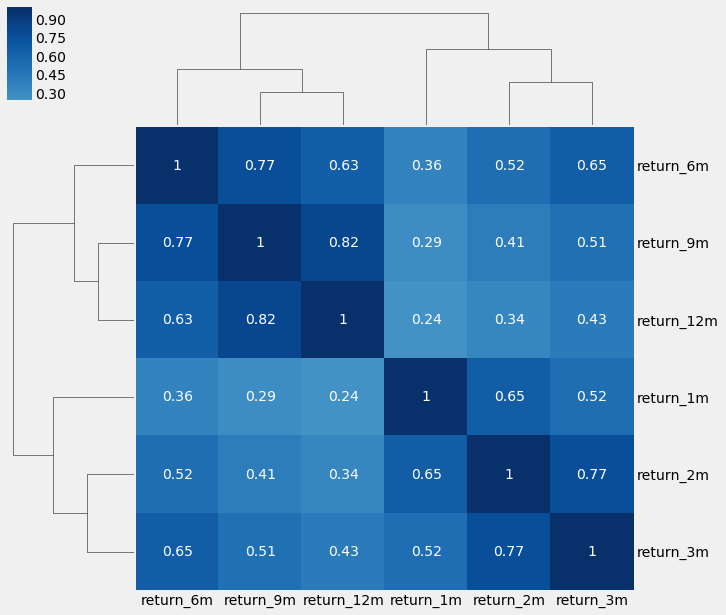

In [10]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

In [11]:
data.index.get_level_values('ticker').nunique()

2328

## Rolling Factor Betas

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [12]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2000-01-31 to 2018-09-30
Freq: M
Data columns (total 5 columns):
Mkt-RF    225 non-null float64
SMB       225 non-null float64
HML       225 non-null float64
RMW       225 non-null float64
CMA       225 non-null float64
dtypes: float64(5)
memory usage: 10.5 KB


In [13]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
Mkt-RF       447517 non-null float64
SMB          447517 non-null float64
HML          447517 non-null float64
RMW          447517 non-null float64
CMA          447517 non-null float64
return_1m    447517 non-null float64
dtypes: float64(6)
memory usage: 22.2+ MB


In [14]:
T = 24
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [15]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,393973.000000,393973.000000,393973.000000,393973.000000,393973.000000,393973.000000
mean,0.990191,0.652521,0.121116,-0.099652,0.012801,1.676976
std,0.950286,1.305079,1.649909,2.073384,2.276595,3.718300
min,-9.486382,-10.353423,-16.104035,-26.812109,-20.629048,-38.236669
25%,0.454541,-0.115142,-0.729210,-1.083547,-1.134267,-0.214351
50%,0.935029,0.564371,0.095212,0.015131,0.038227,1.619522
75%,1.473749,1.352295,0.950864,0.989222,1.172319,3.564994
max,10.277086,10.609692,14.108013,18.232822,18.857485,35.582264


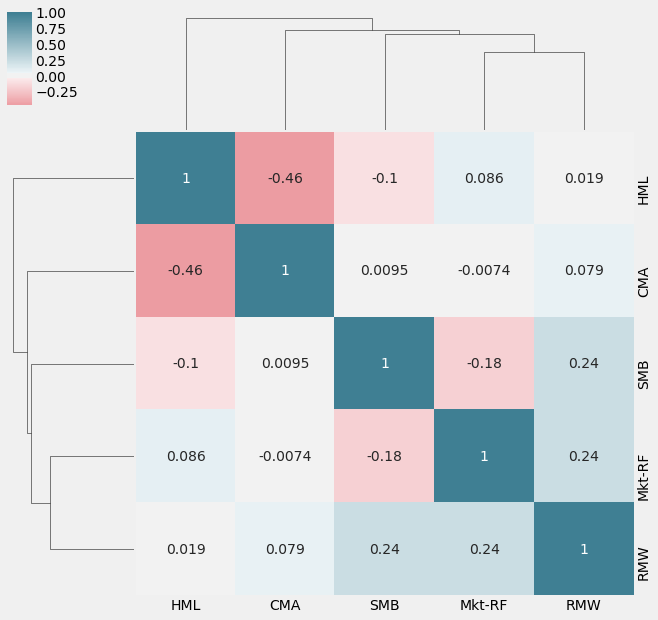

In [16]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [17]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     447517 non-null float64
return_2m     447517 non-null float64
return_3m     447517 non-null float64
return_6m     447517 non-null float64
return_9m     447517 non-null float64
return_12m    447517 non-null float64
CMA           391645 non-null float64
HML           391645 non-null float64
Mkt-RF        391645 non-null float64
RMW           391645 non-null float64
SMB           391645 non-null float64
dtypes: float64(11)
memory usage: 39.5+ MB


### Impute mean for missing factor betas

In [18]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     447517 non-null float64
return_2m     447517 non-null float64
return_3m     447517 non-null float64
return_6m     447517 non-null float64
return_9m     447517 non-null float64
return_12m    447517 non-null float64
CMA           447517 non-null float64
HML           447517 non-null float64
Mkt-RF        447517 non-null float64
RMW           447517 non-null float64
SMB           447517 non-null float64
dtypes: float64(11)
memory usage: 39.5+ MB


## Momentum factors

In [19]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [20]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

In [21]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
# data = data.dropna(thresh=int(len(data.columns) * outlier_threshold))
# data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 25 columns):
return_1m        447517 non-null float64
return_2m        447517 non-null float64
return_3m        447517 non-null float64
return_6m        447517 non-null float64
return_9m        447517 non-null float64
return_12m       447517 non-null float64
CMA              447517 non-null float64
HML              447517 non-null float64
Mkt-RF           447517 non-null float64
RMW              447517 non-null float64
SMB              447517 non-null float64
momentum_2       447517 non-null float64
momentum_3       447517 non-null float64
momentum_6       447517 non-null float64
momentum_9       447517 non-null float64
momentum_12      447517 non-null float64
momentum_3_12    447517 non-null float64
year             447517 non-null int64
month            447517 non-null int64
return_1m_t-1    445189 non-null float64
return_1m_t-2    442861 non-n

## Target: Holding Period Returns

In [22]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [23]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.340055      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.340055  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 30 columns):
return_1m        447517 non-null float64
return_2m        447517 non-null float64
return_3m        447517 non-null float64
return_6m        447517 non-null float64
return_9m        447517 non-null float64
return_12m       447517 non-null float64
CMA              447517 non-null float64
HML              447517 non-null float64
Mkt-RF           447517 non-null float64
RMW              447517 non-null float64
SMB              447517 non-null float64
momentum_2       447517 non-null float64
momentum_3       447517 non-null float64
momentum_6       447517 non-null float64
momentum_9       447517 non-null float64
momentum_12      447517 non-null float64
momentum_3_12    447517 non-null float64
year             447517 non-null int64
month            447517 non-null int64
return_1m_t-1    445189 non-null float64
return_1m_t-2    442861 non-n

## Create age proxy

In [25]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

In [26]:
stocks.marketcap = stocks.marketcap.str.replace('$', '')
stocks['mcap'] = stocks.marketcap.str[-1]
stocks.marketcap =  pd.to_numeric(stocks.marketcap.str[:-1])
stocks = stocks[stocks.mcap.isin(['B', 'M'])]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5766 entries, PIH to ZYME
Data columns (total 4 columns):
marketcap    5766 non-null float64
ipoyear      2792 non-null float64
sector       4849 non-null object
mcap         5766 non-null object
dtypes: float64(2), object(2)
memory usage: 225.2+ KB


In [27]:
stocks.marketcap = stocks.apply(lambda x: x.marketcap * 1000 if x.mcap == 'B' else x.marketcap, axis=1)
stocks.marketcap.describe()

count      5766.000000
mean       7283.441186
std       33439.520061
min           1.060000
25%         160.987500
50%         718.495000
75%        3277.500000
max      903990.000000
Name: marketcap, dtype: float64

In [28]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Freq: -1M
Columns: 2328 entries, A to UFS
dtypes: float64(2328)
memory usage: 3.7 MB


In [29]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

In [30]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [31]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 447517 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 33 columns):
return_1m        447517 non-null float64
return_2m        447517 non-null float64
return_3m        447517 non-null float64
return_6m        447517 non-null float64
return_9m        447517 non-null float64
return_12m       447517 non-null float64
CMA              447517 non-null float64
HML              447517 non-null float64
Mkt-RF           447517 non-null float64
RMW              447517 non-null float64
SMB              447517 non-null float64
momentum_2       447517 non-null float64
momentum_3       447517 non-null float64
momentum_6       447517 non-null float64
momentum_9       447517 non-null float64
momentum_12      447517 non-null float64
momentum_3_12    447517 non-null float64
year             447517 non-null int64
month            447517 non-null int64
return_1m_t-1    445189 non-null float64
return_1m_t-2    442861 non-n

## Store data

In [33]:
with pd.HDFStore('../../data/data.h5') as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])

## Create Dummy variables

In [107]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 465935 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 89 columns):
return_1m                465935 non-null float64
return_2m                465935 non-null float64
return_3m                465935 non-null float64
return_6m                465935 non-null float64
return_9m                465935 non-null float64
return_12m               465935 non-null float64
Mkt-RF                   465935 non-null float64
SMB                      465935 non-null float64
HML                      465935 non-null float64
RMW                      465935 non-null float64
CMA                      465935 non-null float64
momentum_2               465935 non-null float64
momentum_3               465935 non-null float64
momentum_6               465935 non-null float64
momentum_9               465935 non-null float64
momentum_12              465935 non-null float64
momentum_3_12            465935 non-null float64
return_1m_t-

### Mutual Information

#### Original Data

In [169]:
target_labels = [f'target_{i}m' for i in [1,2,3,6,12]]
targets = data.dropna().loc[:, target_labels]

features = data.dropna().drop(target_labels, axis=1)
features.sector = pd.factorize(features.sector)[0]

cat_cols = ['year', 'month', 'msize', 'age', 'sector']
discrete_features = [features.columns.get_loc(c) for c in cat_cols]

In [170]:
mutual_info = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=features, 
                             y=(targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )
    mutual_info[label] = pd.Series(mi, index=features.columns)

In [171]:
mutual_info.sum()

target_1m     0.195866
target_2m     0.227797
target_3m     0.252658
target_6m     0.316750
target_12m    0.385409
dtype: float64

#### Normalized MI Heatmap

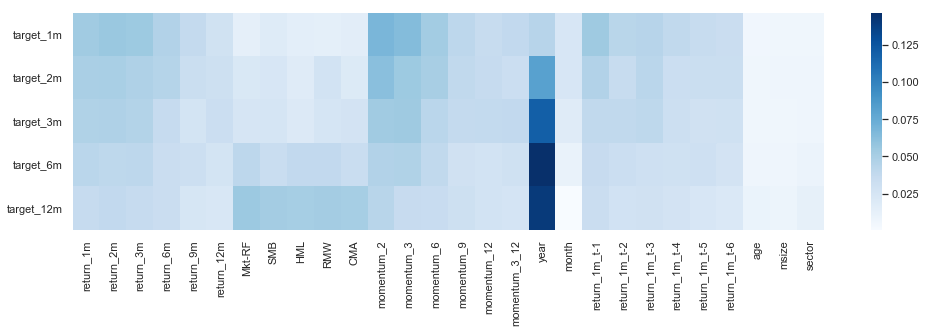

In [172]:
fig, ax= plt.subplots(figsize=(15, 4))
sns.heatmap(mutual_info.div(mutual_info.sum()).T, ax=ax, cmap='Blues');

#### Dummy Data

In [176]:
target_labels = [f'target_{i}m' for i in [1, 2, 3, 6, 12]]
dummy_targets = dummy_data.dropna().loc[:, target_labels]

dummy_features = dummy_data.dropna().drop(target_labels, axis=1)
cat_cols = [c for c in dummy_features.columns if c not in features.columns]
discrete_features = [dummy_features.columns.get_loc(c) for c in cat_cols]

In [178]:
mutual_info_dummies = pd.DataFrame()
for label in target_labels:
    mi = mutual_info_classif(X=dummy_features, 
                             y=(dummy_targets[label]> 0).astype(int),
                             discrete_features=discrete_features,
                             random_state=42
                            )    
    mutual_info_dummies[label] = pd.Series(mi, index=dummy_features.columns)

In [179]:
mutual_info_dummies.sum()

target_1m     0.197985
target_2m     0.230910
target_3m     0.256673
target_6m     0.322516
target_12m    0.392777
dtype: float64

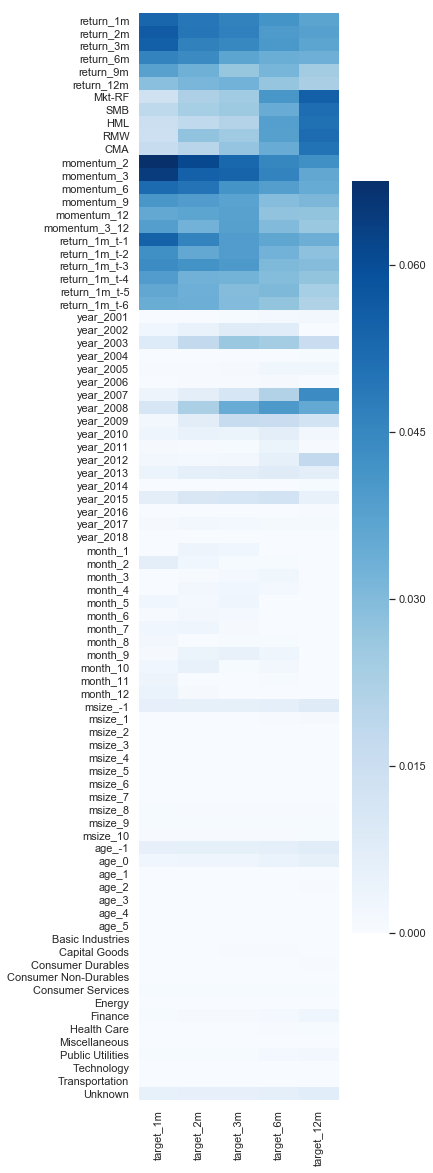

In [188]:
fig, ax= plt.subplots(figsize=(4, 20))
sns.heatmap(mutual_info_dummies.div(mutual_info_dummies.sum()), ax=ax, cmap='Blues');